## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [156]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from utils import dfm
from utils.abc import ABCSampler
from utils import price_rogers_2014_binned
from tqdm.notebook import tqdm
from scipy.stats import gamma
from functools import partial

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


My ABC setup requires

- a prior occurrence estimate.
- a candidate generator for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

In [2]:
kois = dfm.get_kois()
stellar = dfm.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
kois = kois[np.isfinite(kois["koi_prad"])]

[192950   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

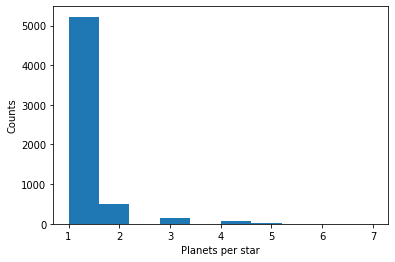

In [3]:
#starcounts = np.concatenate((np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten(), np.zeros((len(stellar[~stellar["kepid"].isin(kois["kepid"])]),))))
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
bincounts = np.bincount(solarsyssizes)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(solarsyssizes)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [4]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
koi_radii = kois["koi_prad"]
koi_periods = kois["koi_period"]

In [5]:
lam = np.mean(solarsyssizes)
# lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10) 
print([sum(planet_numbers == i) for i in range(max(planet_numbers))])

[61131, 71888, 42518, 16962, 4983, 1172, 220, 36]


(array([6.1131e+04, 7.1888e+04, 4.2518e+04, 1.6962e+04, 0.0000e+00,
        4.9830e+03, 1.1720e+03, 2.2000e+02, 3.6000e+01, 7.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

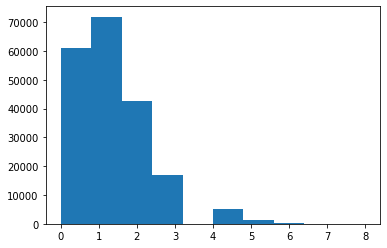

In [6]:
plt.hist(planet_numbers)

In [402]:
period = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period), np.log(rp)
log_p = np.append(log_p, np.log(640))
log_r = np.append(log_r, np.log(20))
period_rng = (min(period), max(period))
rp_rng = (min(rp), max(rp))

f = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]
# f = np.ones(shape=(len(period), len(rp)))
f /= np.sum(f)

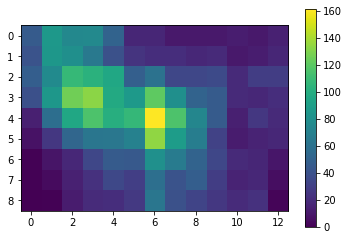

In [403]:
plt.imshow(np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]) # I guess that's sorta like an H-R diagram?
plt.colorbar()

In [404]:
bucket = np.random.choice(f.size, p=f.flatten())
i, j = bucket // f.shape[1], bucket % f.shape[1] 
synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
ecc = stats.rayleigh(scale=0.03).rvs()
cosincl = np.random.uniform(-1, 1)
print("Generated planet with period {0} days, radius {1} Earth radii, eccentricity {2}, cos of orbital inclination {3}.".format(np.round(synth_p, 3), np.round(synth_r, 3), np.round(ecc, 3), np.round(cosincl, 3)))

Generated planet with period 72.189 days, radius 2.151 Earth radii, eccentricity 0.092, cos of orbital inclination 0.825.


In [405]:
cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

In [406]:
def pcomp_vectors(stars, periods, rp, eccs):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    
    mstars = np.array(stars['mass'])
    rstars = np.array(stars['radius'])
    cdpp = np.array(stars[cdpp_cols], dtype=float)
    dataspan = np.array(stars['dataspan'])
    dutycycle = np.array(stars['dutycycle'])
    mesthres_cols_stars = np.array(stars[mesthres_cols], dtype=float)
    
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    # sigma = np.apply_along_axis(np.interp, 0, tau, cdpp_vals, cdpp)
    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    # Compute the radius ratio and estimate the S/N.
    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    
    M = dataspan / periods
    f = dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) & (M >= 2.0)
    pwins = pw * msk
    
    pgeom = 1. / (aor * (1 - eccs*eccs)) * (aor > 1.0)
    
    return pdets * pwins * pgeom

/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


(array([5201., 1001.,  470.,  173.,   59.,   27.,   10.,   13.,   11.,
           7.]),
 array([0.        , 0.09990394, 0.19980789, 0.29971183, 0.39961577,
        0.49951971, 0.59942366, 0.6993276 , 0.79923154, 0.89913549,
        0.99903943]),
 <a list of 10 Patch objects>)

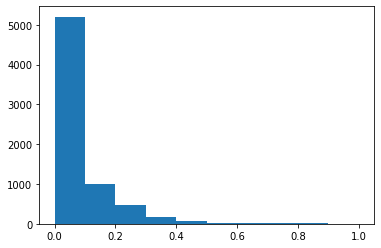

In [407]:
combined = pd.merge(kois, stellar, on='kepid')
pcomp = partial(dfm.get_completeness, pgam=pgam, mesthres_cols=mesthres_cols, mesthres_vals=mesthres_vals)
pcomps = pcomp_vectors(combined, combined['koi_period'], combined['koi_prad'], combined['koi_eccen'])
plt.hist(pcomps[~np.isnan(pcomps)])

In [408]:
%timeit pcomp_vectors(combined, combined['koi_period'], combined['koi_prad'], combined['koi_eccen'])

286 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [409]:
# this has some nans
# check that dfm's completeness couldn't do any better
incomplete_ids = combined.kepid[np.where(np.isnan(pcomps))[0]]
for incomp in incomplete_ids:
    incomp_row = combined[combined.kepid == incomp]
    assert np.all(np.isnan(pcomp(incomp_row.iloc[0], incomp_row['koi_period'],
                                incomp_row['koi_prad'], incomp_row['koi_eccen']).to_numpy()))

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [410]:
sum(np.isnan(pcomps))

92

In [475]:
t0_range = (min(combined['koi_time0']), max(combined['koi_time0']))

def generate_planet_catalog(f, stars):
    '''
    Takes in the occurrence rate matrix f and generates `num_planets' planets, 
    represented as a matrix of state (row) vectors.
    
    Each row has: period in days; radius in Earth radii; eccentricity; cosine of inclination; impact parameter;
    time of first transit in BJD; fractional transit depth; transit duration in days; is_detected (bool).
    
    Arguments
    ---------
    f : np.ndarray
    f = f(r, p); occurrence rate prior that we sample p and r from.
    
    stars : list
    A list of tuples with stellar parameters (may edit this to deal with dataframe later.)
    '''
    # [period, radius, ecc, cosincl, impact param b, t0, transit depth d, transit duration D, is_detected]
    lam = np.sum(f)
    num_stars = len(stars)
    planet_params = ['kepid', 'period', 'prad', 'ecc', 'cosincl', 'b', 't0', 'd', 'D']
    nums_planets = np.minimum(stats.poisson(lam).rvs((num_stars,)), 10)
    params_size = len(planet_params)
    planets_matrix = np.empty(shape=(0, params_size))
    for num_planets, star in tqdm(zip(nums_planets, stars)):
        k = 0
        fails = 0
        while k < num_planets:
            bucket = np.random.choice(f.size, p=f.flatten() / np.sum(f))
            i, j = bucket // f.shape[1], bucket % f.shape[1]
            synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
            synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
            ecc = stats.rayleigh(scale=0.03).rvs()
            cosincl = np.random.uniform(0, 1) 
            r = synth_r / star.radius * 0.009158 # conversion from R_earth to R_sun
            b = np.random.uniform(0, 1) # Hsu 2018 ignores the possibility of b > 1
            t0 = np.random.uniform(*t0_range) 
            # constrain period
            # does the planet transit during the observation window?
            # refine pdet
            d = r ** 2
            aor = get_a(synth_p, star.mass) / star.radius
            arcsin_arg = np.sqrt((1 + r) ** 2 - b ** 2) / aor
            if arcsin_arg > 1:
                fails += 1
            else:
                D = (synth_p / np.pi) * np.arcsin(arcsin_arg)
                tau0 = synth_p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
                T = 2 * tau0 * np.sqrt(1 - b ** 2)
                tau = 2 * tau0 * r / np.sqrt(1 - b ** 2)
                f0 = 1
                texp = 1765.5 / 60 / 60 / 24 # s to days
                gamma = 1 / (6.5 / 60 / 60 / 24) # inverse s to inverse days
                sigma = 1 # 'model uncertainty'

                price_uncertainty_params = [d, T, tau, f0, texp, synth_p, gamma, sigma]
                var_d = abs(price_rogers_2014_binned.prVarDelta(*price_uncertainty_params)) # abs is stopgap
                var_D = 2 * abs(price_rogers_2014_binned.prVarTau(*price_uncertainty_params)) + abs(
                    price_rogers_2014_binned.prVarTc(*price_uncertainty_params))
                var_b = abs(price_rogers_2014_binned.prVarBsq(*price_uncertainty_params))

                d += np.random.normal(0, np.sqrt(var_d))
                # D += np.random.normal(0, np.sqrt(var_D))
                # b += np.random.normal(0, np.sqrt(var_b))
                if all([b > 0, d > 0, D > 0, arcsin_arg <= 1]):
                    new_planet = np.array([star.kepid, synth_p, synth_r, ecc, cosincl, 
                                           b, t0, d, D])
                    planets_matrix = np.vstack((planets_matrix, new_planet))
                    k += 1
                    fails = 0
                else:
                    fails += 1
                if fails > 5:
                    # bad_kepids.append(star.kepid) - see if these are FPs, or if p/r are extreme
                    k = num_planets
                
    catalog = pd.DataFrame(planets_matrix, columns=planet_params)
    combined_synth = pd.merge(catalog, stellar, on='kepid')
    probs = pcomp_vectors(combined_synth, combined_synth['period'], 
                          combined_synth['prad'], combined_synth['ecc'])
    detected = np.random.binomial(1, probs)
    catalog['is_detected'] = detected
    return catalog.astype({'kepid': np.int64, 'is_detected': bool})

In [455]:
planet_catalog = np.empty((0, 9))
num_stars = 100 or len(stellar)
stellar_sample = [row for row in stellar.sample(n=num_stars).itertuples()]

In [457]:
catalog_synth = generate_planet_catalog(f, stellar_sample)
if len(stellar_sample) == len(stellar):
    catalog_synth.to_csv('./catalog_synth.csv')

In [458]:
catalog_synth

,kepid,period,prad,ecc,cosincl,b,t0,d,D,is_detected
0,9455428,5.266959,1.184894,0.027189,0.663316,0.762572,2.455486e+06,0.153579,0.081299,False
1,9455428,5.282145,1.753299,0.055365,0.485687,0.646295,2.455518e+06,0.024883,0.096175,False
2,7821063,15.155526,1.333898,0.010834,0.036027,0.066449,2.455560e+06,0.162840,0.204661,False
3,2846335,12.057859,1.561075,0.042527,0.476061,0.590506,2.455421e+06,0.007269,0.188279,False
4,9051076,8.957102,1.941554,0.004380,0.156000,0.851466,2.455067e+06,0.049440,0.113146,False
...,...,...,...,...,...,...,...,...,...,...
88,6139856,7.129612,1.558651,0.047366,0.184413,0.300607,2.455060e+06,0.754283,0.153077,False
89,11872545,6.524566,13.862215,0.040260,0.839271,0.788575,2.455320e+06,0.031955,0.140382,False
90,10526563,9.881694,2.085201,0.045321,0.833037,0.131130,2.455321e+06,0.114959,0.162876,True
91,11450210,100.303393,5.614886,0.037806,0.632783,0.076577,2.455224e+06,0.013464,0.341694,False


In [459]:
sum(catalog_synth.is_detected)

6

(array([ 7.,  5.,  4., 16., 15., 12., 13.,  7.,  3., 11.]),
 array([-0.5999853 ,  0.02884253,  0.65767037,  1.2864982 ,  1.91532604,
         2.54415387,  3.1729817 ,  3.80180954,  4.43063737,  5.05946521,
         5.68829304]),
 <a list of 10 Patch objects>)

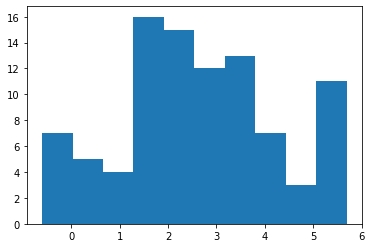

In [460]:
plt.hist(np.log(catalog_synth.period))

(array([ 4.,  4., 24., 25., 13.,  5.,  6.,  6.,  3.,  3.]),
 array([-6.87719438e-01, -3.43348482e-01,  1.02247447e-03,  3.45393431e-01,
         6.89764387e-01,  1.03413534e+00,  1.37850630e+00,  1.72287725e+00,
         2.06724821e+00,  2.41161917e+00,  2.75599012e+00]),
 <a list of 10 Patch objects>)

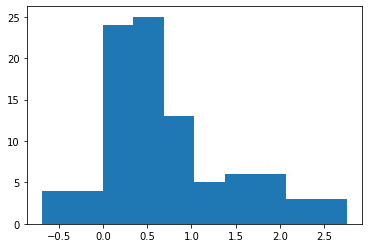

In [461]:
plt.hist(np.log(catalog_synth.prad))

In [462]:
N = np.zeros_like(f)
detected = catalog_synth[catalog_synth.is_detected]
period_bins = np.digitize(np.log(detected.period), log_p)
radius_bins = np.digitize(np.log(detected.prad), log_r)
for i, j in zip(period_bins, radius_bins):
    if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
        N[i][j] += 1
        
N /= len(stellar_sample)

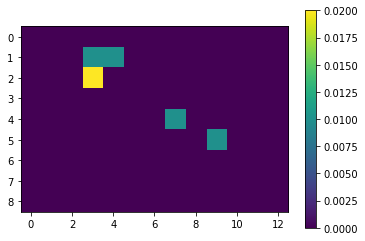

In [463]:
plt.imshow(N)
plt.colorbar()

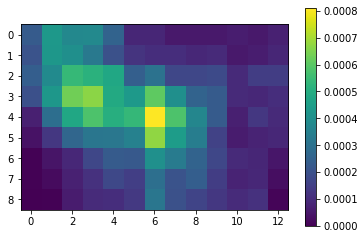

In [464]:
sample_N = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0] / len(stellar)
plt.imshow(sample_N)
plt.colorbar()

In [465]:
diff = N - sample_N
statistic = np.sum(diff ** 2)
statistic

0.0007633209903355076

In [543]:
import copy
kois_abc = np.array([np.vstack((kois.koi_period, kois.koi_prad, np.ones(len(kois)))).T]) # filter on FPs
kois_abc

array([[[ 2.47061339, 12.85      ,  1.        ],
        [ 2.20473536, 16.39      ,  1.        ],
        [23.66836427,  3.06      ,  1.        ],
        ...,
        [ 3.27582262,  2.18      ,  1.        ],
        [15.87364565,  1.61      ,  1.        ],
        [17.97979059,  2.18      ,  1.        ]]])

In [581]:
stellar_sample_size = 100
stellar_sample = [row for row in stellar.sample(n=stellar_sample_size).itertuples()]

class OccurrencePrior(stats.rv_continuous):
    def pdf(self, f):
        return np.prod(np.exp(-f))
    
    def rvs(self):
        return stats.expon.rvs(size=(len(period), len(rp)))
    
def occurrence_candidate_getter(f):
    def candidate(size=1):
        catalogs = [generate_planet_catalog(f, stellar_sample) for _ in range(size)]
        return np.array([np.vstack((c.period, c.prad, c.is_detected)).T for c in catalogs])
    return candidate
    
def occurrence_distance(s1, s2):
    return np.sum((s1 - s2) ** 2)

def occurrence_statistic(catalog):
    N = np.zeros_like(f)
    found_inds = np.where(catalog[0,:,2] == 1)[0]
    detected = catalog[0][found_inds] # the 0 is jank and should be changed
    if detected.shape[0] == catalog.shape[1]:
        Nstars = len(stellar)
    else:
        Nstars = stellar_sample_size # this is slightly jank and will fail 1 time in a trillion
    period_bins = np.digitize(np.log(detected[:,0]), log_p)
    radius_bins = np.digitize(np.log(detected[:,1]), log_r)
    for i, j in zip(period_bins, radius_bins):
        if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
            N[i][j] += 1
    return N / Nstars
    
OccurrenceABCSampler = ABCSampler(OccurrencePrior(), occurrence_candidate_getter, occurrence_distance, occurrence_statistic)


In [557]:
candidate = occurrence_candidate_getter(f)()

In [584]:
abc_f = OccurrenceABCSampler.sample(kois_abc, threshold=1e-2)

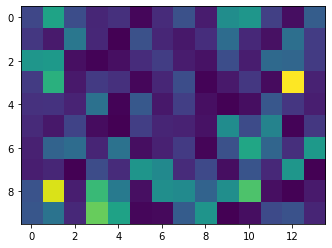

In [585]:
plt.imshow(abc_f)

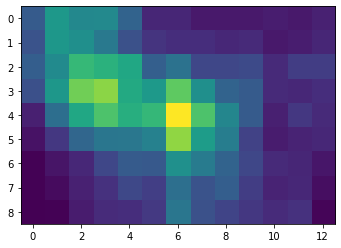

In [586]:
plt.imshow(f)

In [595]:
stellar_sample_size = len(stellar)
stellar_sample = [row for row in stellar.sample(n=stellar_sample_size).itertuples()]
OccurrenceABCSampler = ABCSampler(OccurrencePrior(), occurrence_candidate_getter, occurrence_distance, occurrence_statistic)
abc_f_full = OccurrenceABCSampler.sample(kois_abc, threshold=1e-5)

KeyboardInterrupt: 

impact parameter > 1: either a FP, or on the edge of the star. The transiting object has to be big, and often that's actually a star.

In [587]:
abc_pmc_f = OccurrenceABCSampler.sample_pmc(kois_abc, [1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 1)

ValueError: m has more than 2 dimensions

In [605]:
eps = -1e-8
i = 10
p = combined['koi_period'][i]
r = combined['koi_prad'][i]
rstar = combined['radius'][i]
ror = r / rstar * 0.009158
d = ror ** 2
b = combined['koi_impact'][i]
cosincl = np.cos(combined['koi_incl'][i] * np.pi / 180)
ecc = stats.rayleigh(scale=0.03).rvs() * 0
aor = get_a(p, combined['mass'][i]) / rstar
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
D = (p / np.pi) * np.arcsin(np.sqrt((1 + p / rstar) ** 2 - b ** 2) / aor)
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
tau = 2 * tau0 * r / np.sqrt(1 - b ** 2)
f0 = 1
texp = 1765.5 / 60 / 60 / 24 # s to days
gamma = 1 / eps # inverse s to inverse days
sigma = 1 # 'model uncertainty'
price_uncertainty_params = [d, T, tau, f0, texp, p, gamma, sigma]
print(price_rogers_2014_binned.prVarDelta(*price_uncertainty_params))

3.345100551155165e-09


In [601]:
print(p, r, rstar, b, cosincl, ecc)

47.9035211 2.56 1.3319999999999999 0.1875 0.0008726645152351565 0.0


In [357]:
bad_kepids = np.load('./bad_kepids.npy')
len(set(bad_kepids) & set(kois.kepid))

178